<a href="https://colab.research.google.com/github/google-research/google-research/blob/master/graph_sampler/molecule_sampling_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Copyright 2022 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

In [ ]:
# Install graph_sampler
!git clone https://github.com/google-research/google-research.git
!pip install google-research/graph_sampler

In [ ]:
from rdkit import Chem
import rdkit.Chem.Draw
from graph_sampler import molecule_sampler
from graph_sampler import stoichiometry
import numpy as np

# Generating samples from a single stoichiometry

In [ ]:
stoich = stoichiometry.Stoichiometry({'C': 10, 'O': 2, 'N': 3, 'H': 16, 'F': 2, 'O-': 1, 'N+': 1})
assert stoichiometry.is_valid(stoich), 'Cannot form a connected graph with this stoichiometry.'
print('Number of heavy atoms:', sum(stoich.counts.values()) - stoich.counts['H'])

Number of heavy atoms: 19


In [ ]:
%%time
sampler = molecule_sampler.MoleculeSampler(stoich,
                                           relative_precision=0.03,
                                           rng_seed=2044365744)
weighted_samples = [graph for graph in sampler]
stats = sampler.stats()
rejector = molecule_sampler.RejectToUniform(weighted_samples,
                                            max_importance=stats['max_final_importance'],
                                            rng_seed=265580748)
uniform_samples = [graph for graph in rejector]
print(f'generated {len(weighted_samples)}, kept {len(uniform_samples)}, '
      f'estimated total: {stats["estimated_num_graphs"]:.2E} ± '
      f'{stats["num_graphs_std_err"]:.2E}')

generated 3646, kept 115, estimated total: 7.06E+15 ± 2.11E+14
CPU times: user 17.4 s, sys: 1.44 s, total: 18.9 s
Wall time: 18.1 s


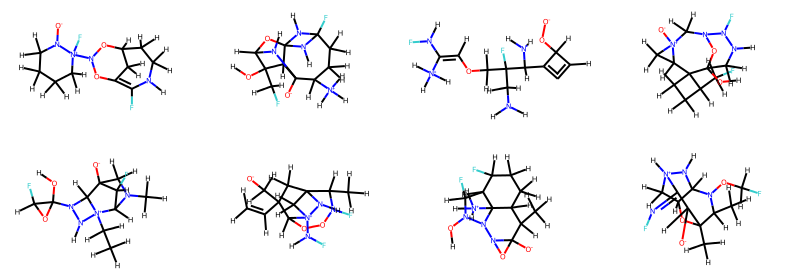

In [ ]:
#@title Draw some examples
mols = [molecule_sampler.to_mol(g) for g in uniform_samples]
Chem.Draw.MolsToGridImage(mols[:8], molsPerRow=4, subImgSize=(200, 140))

# Combining samples from multiple stoichiometries
Here we'll generate random molecules with 5 heavy atoms selected from C, N, and O. These small numbers are chosen just to illustrate the code. In this small an example, you could just enumerate all molecules. For large numbers of heavy atoms selected from a large set, you'd want to parallelize a lot of this.

In [ ]:
#@title Enumerate valid stoichiometries subject to the given constraint
heavy_elements = ['C', 'N', 'O']
num_heavy = 5

# We'll dump stoichiometries, samples, and statistics into a big dictionary.
all_data = {}
for stoich in stoichiometry.enumerate_stoichiometries(num_heavy, heavy_elements):
  key = ''.join(stoich.to_element_list())
  all_data[key] = {'stoich': stoich} 

max_key_size = max(len(k) for k in all_data.keys())
print(f'{len(all_data)} stoichiometries')

90 stoichiometries


In [ ]:
#@title For each stoichiometry, generate samples and estimate the number of molecules
for key, data in all_data.items():
  sampler = molecule_sampler.MoleculeSampler(data['stoich'], relative_precision=0.2)
  data['weighted_samples'] = [graph for graph in sampler]
  stats = sampler.stats()
  data['stats'] = stats
  rejector = molecule_sampler.RejectToUniform(data['weighted_samples'],
                                              max_importance=stats['max_final_importance'])
  data['uniform_samples'] = [graph for graph in rejector]
  print(f'{key:>{max_key_size}}:\tgenerated {len(data["weighted_samples"])},\t'
        f'kept {len(data["uniform_samples"])},\t'
        f'estimated total {int(stats["estimated_num_graphs"])} ± {int(stats["num_graphs_std_err"])}')

          OOOOOHH:	generated 500,	kept 500,	estimated total 1 ± 0
            OOOOO:	generated 366,	kept 366,	estimated total 1 ± 0
         NOOOOHHH:	generated 500,	kept 336,	estimated total 3 ± 0
           NOOOOH:	generated 438,	kept 378,	estimated total 4 ± 0
        NNOOOHHHH:	generated 500,	kept 94,	estimated total 8 ± 0
          NNOOOHH:	generated 460,	kept 197,	estimated total 15 ± 0
            NNOOO:	generated 455,	kept 121,	estimated total 4 ± 0
       NNNOOHHHHH:	generated 500,	kept 126,	estimated total 10 ± 0
         NNNOOHHH:	generated 472,	kept 205,	estimated total 23 ± 0
           NNNOOH:	generated 469,	kept 138,	estimated total 14 ± 0
      NNNNOHHHHHH:	generated 500,	kept 93,	estimated total 6 ± 0
        NNNNOHHHH:	generated 468,	kept 91,	estimated total 18 ± 0
          NNNNOHH:	generated 477,	kept 182,	estimated total 17 ± 0
            NNNNO:	generated 489,	kept 363,	estimated total 4 ± 0
     NNNNNHHHHHHH:	generated 500,	kept 245,	estimated total 2 ± 0
       

In [ ]:
#@title Combine into one big uniform sampling of the whole space
bucket_sizes = [data['stats']['estimated_num_graphs'] for data in all_data.values()]
sample_sizes = [len(data['uniform_samples']) for data in all_data.values()]
base_iters = [data['uniform_samples'] for data in all_data.values()]

aggregator = molecule_sampler.AggregateUniformSamples(bucket_sizes, sample_sizes, base_iters)
merged_uniform_samples = [graph for graph in aggregator]

total_estimate = sum(data['stats']['estimated_num_graphs'] for data in all_data.values())
total_variance = sum(data['stats']['num_graphs_std_err']**2 for data in all_data.values())
total_std = np.sqrt(total_variance)

print(f'{len(merged_uniform_samples)} samples after merging, of an estimated '
      f'{total_estimate:.1f} ± {total_std:.1f}')

842 samples after merging, of an estimated 3563.4 ± 22.0


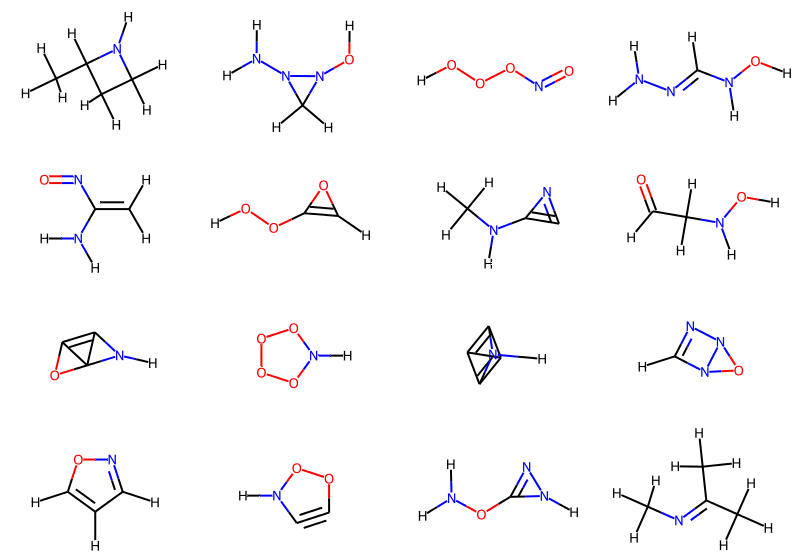

In [ ]:
#@title Draw some examples
mols = [molecule_sampler.to_mol(g) for g in merged_uniform_samples]
Chem.Draw.MolsToGridImage(np.random.choice(mols, size=16), molsPerRow=4, subImgSize=(200, 140))